# Object-Centric 3D Tracking and Open-Vocabulary Querying Pipeline

This notebook implements a modern, object-centric pipeline for 3D tracking and open-vocabulary querying in RGB-D scenes. The pipeline leverages:

- **DINOv2** for robust 3D object feature extraction and tracking across frames.
- **CLIP** for open-vocabulary text-to-object queries.
- **Accurate 2D/3D visualization**: After a query, both 3D (rerun) and 2D (projected) visualizations are shown for the best-matching object and frame.

All code is streamlined for clarity, modularity, and extensibility. Each section is documented to explain its role in the pipeline.

## 1. Dependencies and Imports

This section installs and imports all required libraries and utility functions for the pipeline, including DINOv2, CLIP, SAM, and visualization tools.

In [43]:
# Install dependencies
!pip install --upgrade pip
!pip install torch==2.4.0+cu121 torchvision==0.19.0+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.44.0 huggingface-hub==0.24.0 pillow numpy opencv-python open3d ipympl rerun-sdk[notebook]

Looking in indexes: https://download.pytorch.org/whl/cu121


In [44]:
# Import required libraries
import os
from typing import Dict, List, Optional
import cv2
import numpy as np
from PIL import Image
import torch
from tqdm.notebook import tqdm

# Import lab utility functions
from lab_utils.data_utils import get_frame_list, load_camera_poses, validate_and_align_frame_data
from lab_utils.model_loaders import load_sam_model, load_dino_model, load_clip_model

## 2. Frame Processing Functions

This section defines the core frame processing function that handles individual frames: segmenting objects with SAM, extracting DINOv2 and CLIP features, computing 3D centroids, and updating the object tracker.

In [45]:
class Config:
    """Configuration class for the object-centric 3D tracking and querying pipeline."""
    
    def __init__(self):
        # Data paths - update these to match your dataset structure
        self.RGB_PATH = "ARKitScenesData/47333473/47333473_frames/lowres_wide"
        self.DEPTH_PATH = "ARKitScenesData/47333473/47333473_frames/lowres_depth"
        self.INTRINSICS_PATH = "ARKitScenesData/47333473/47333473_frames/lowres_wide_intrinsics"
        self.TRAJ_FILE_PATH = "ARKitScenesData/47333473/47333473_frames/lowres_wide.traj"
        
        # Pipeline configuration
        self.PIPELINE = {
            'dino_model': 'facebook/dinov2-base',  # DINOv2 model for tracking
            'clip_model': 'openai/clip-vit-base-patch32',  # CLIP model for querying
            'frame_skip': 7,  # Process every 7th frame
            'max_frames': 35,  # Maximum frames to process
        }
        
        # SAM configuration - STRICTER to reduce object count
        self.SAM_CONFIG = {
            'model_size': 'base',  # SAM model size: 'base', 'large', or 'huge'
            'grid_size': 3,  # Grid size for point prompts: 3x3 = 9 prompts (was 4 or 6)
            'pred_iou_thresh': 0.95,  # IoU threshold for mask quality: higher = fewer objects
            'stability_score_thresh': 0.98,  # Stability threshold: higher = fewer objects  
            'sam_confidence_threshold': 0.85,  # Confidence threshold: higher = fewer objects
            'min_mask_region_area': 1500,  # Minimum mask area: larger = fewer small objects (was 500)
            'padding_ratio_image_crops': 0.1,  # Padding for feature extraction crops
        }
        
        # Object tracking parameters - STRICTER for better association
        self.TRACKING = {
            'feature_sim_threshold': 0.85,  # DINOv2 similarity: higher = stricter matching (was 0.8)
            'iou_threshold': 0.6,  # IoU threshold: higher = stricter spatial overlap (was 0.5)
            'max_distance_threshold': 0.2,  # Max 3D distance: closer = stricter tracking (was 0.3)
        }
        
        # Visualization settings
        self.RERUN_WIDTH = 1600
        self.RERUN_HEIGHT = 800
        
        # 3D processing parameters
        self.DEPTH_SCALE = 1000.0  # Depth scale factor (mm to meters)
        self.MIN_DEPTH = 0.1  # Minimum valid depth (meters)
        self.MAX_DEPTH = 10.0  # Maximum valid depth (meters)
        self.MAX_POINTS_PER_OBJECT = 5000  # Max points per object for efficiency

## 3. Pipeline Execution Functions

This section defines the main functions that orchestrate the pipeline: model loading, frame processing, object tracking, and querying. These functions are the entry points for running the full object-centric tracking and querying workflow.

In [46]:
def run_object_tracking_pipeline(config: Config, 
                                 max_frames: int = None,
                                 frame_skip: int = None,
                                 grid_size: int = 6) -> Dict:
    """Run the full object-centric 3D tracking pipeline with DINOv2 and CLIP."""
    
    # Use parameters or fall back to config defaults
    actual_max_frames = max_frames if max_frames is not None else config.PIPELINE['max_frames']
    actual_frame_skip = frame_skip if frame_skip is not None else config.PIPELINE['frame_skip']
    
    print(f"Starting pipeline with max_frames={actual_max_frames}, frame_skip={actual_frame_skip}, grid_size={grid_size}")
    
    # Load models
    print("Loading models...")
    sam_model, sam_processor, device = load_sam_model(model_size='base')
    dino_model, dino_processor, _ = load_dino_model(model_name=config.PIPELINE['dino_model'], device=device)
    clip_model, clip_processor, _ = load_clip_model(model_name=config.PIPELINE['clip_model'], device=device)
    
    # Get DINOv2 feature dimension
    dummy_input = dino_processor(images=Image.new('RGB', (224, 224)), return_tensors="pt")
    dummy_input = {k: v.to(device) for k, v in dummy_input.items()}
    with torch.no_grad():
        dummy_features = dino_model(**dummy_input).last_hidden_state.mean(dim=1)
    feature_dim = dummy_features.shape[-1]
    print(f"DINOv2 feature dimension: {feature_dim}")
    
    # Load camera data and frames (using configurable frame_skip)
    camera_poses = load_camera_poses(config.TRAJ_FILE_PATH)
    frames_metadata = get_frame_list(config.RGB_PATH, actual_frame_skip)
    print(f"Selected {len(frames_metadata)} frames with frame skip of {actual_frame_skip}")
    
    aligned_frames = validate_and_align_frame_data(
        frames_metadata, camera_poses, config.RGB_PATH, config.DEPTH_PATH, config.INTRINSICS_PATH)
    
    if not aligned_frames:
        print("No aligned frames found!")
        return {}
    
    object_tracker = ObjectTracker(feature_dim=feature_dim)
    frames_to_process = aligned_frames[:actual_max_frames]
    print(f"Processing {len(frames_to_process)} frames...")
    
    all_results = []
    for frame_data in tqdm(frames_to_process, desc="Processing frames"):
        # Update process_frame to accept grid_size
        frame_results = process_frame_with_grid(
            frame_data, sam_model, sam_processor,
            dino_model, dino_processor,
            clip_model, clip_processor,
            object_tracker, device, config, grid_size)
        all_results.append(frame_results)
    
    print(f"\nObject Tracking Results:")
    print(f"  Tracked objects: {len(object_tracker.tracks)}")
    
    return {
        'object_tracker': object_tracker,
        'dino_model': dino_model,
        'dino_processor': dino_processor,
        'clip_model': clip_model,
        'clip_processor': clip_processor,
        'device': device,
        'frame_results': all_results
    }

## 4. ObjectTracker Class

This section defines the ObjectTracker class, which manages the association and tracking of objects across frames using DINOv2 features. It stores both DINOv2 and CLIP features for each object, enabling robust tracking and open-vocabulary querying.

In [47]:
class ObjectTracker:
    """Tracks objects in 3D using DINOv2 features for association, stores both DINOv2 and CLIP features."""
    
    def __init__(self, feature_dim, iou_threshold=0.3, feature_sim_threshold=0.7):
        self.tracks = []  # List of dicts: {'id', 'centroid_3d', 'dino_features', 'clip_features', 'history', ...}
        self.next_id = 0
        self.feature_dim = feature_dim
        self.iou_threshold = iou_threshold
        self.feature_sim_threshold = feature_sim_threshold
    
    def add_or_update_object(self, centroid_3d, dino_features, clip_features, object_data):
        """Add new object or update existing track based on DINOv2 feature similarity."""
        best_track = None
        best_sim = -float('inf')
        
        for track in self.tracks:
            # Use both feature similarity and spatial distance for matching
            feat_sim = self._feature_similarity(dino_features, track['dino_features'])
            spatial_dist = np.linalg.norm(centroid_3d - track['centroid_3d'])
            
            # Combined score (feature similarity is primary, spatial distance is secondary)
            if feat_sim > self.feature_sim_threshold and spatial_dist < 1.0:  # 1 meter threshold
                combined_sim = feat_sim - (spatial_dist * 0.1)  # Slight penalty for distance
                if combined_sim > best_sim:
                    best_sim = combined_sim
                    best_track = track
        
        if best_track:
            # Update existing track
            best_track['centroid_3d'] = centroid_3d
            best_track['bbox_3d'] = object_data['bbox_3d']
            best_track['dino_features'] = dino_features
            best_track['clip_features'] = clip_features
            best_track['history'].append(object_data)
            return best_track['id']
        else:
            # Create new track
            new_track = {
                'id': self.next_id,
                'centroid_3d': centroid_3d,
                'bbox_3d': object_data['bbox_3d'],
                'dino_features': dino_features,
                'clip_features': clip_features,
                'history': [object_data],
            }
            self.tracks.append(new_track)
            track_id = self.next_id
            self.next_id += 1
            return track_id
    
    def _feature_similarity(self, feat1, feat2):
        """Compute cosine similarity between two feature vectors."""
        feat1 = feat1 / (np.linalg.norm(feat1) + 1e-8)
        feat2 = feat2 / (np.linalg.norm(feat2) + 1e-8)
        return float(np.dot(feat1, feat2))
    
    def get_all_tracks(self):
        """Return all tracked objects."""
        return self.tracks

## 5. Query and Visualization Functions

This section defines functions for querying tracked objects using CLIP features and visualizing the results. The main function finds the best-matching object for a text query and shows both 3D and 2D visualizations.

In [48]:
def query_and_visualize_objects(pipeline_results, query_text, config):
    """Query tracked objects using CLIP, visualize 3D and best 2D frame."""
    object_tracker = pipeline_results['object_tracker']
    clip_model = pipeline_results['clip_model']
    clip_processor = pipeline_results['clip_processor']
    device = pipeline_results['device']
    
    # Compute CLIP features for query
    query_features = extract_clip_text_features(query_text, clip_model, clip_processor, device)
    
    # Find best-matching object (highest CLIP similarity)
    best_obj, best_sim = None, -float('inf')
    for track in object_tracker.get_all_tracks():
        sim = cosine_similarity(query_features, track['clip_features'])
        if sim > best_sim:
            best_sim = sim
            best_obj = track
    
    if best_obj is None:
        print(f"No object found for query: {query_text}")
        return
    
    print(f"Best match: Track ID {best_obj['id']} (CLIP sim: {best_sim:.3f})")
    
    # Visualize 3D with rerun
    visualize_object_3d(best_obj, config)
    
    # Visualize best 2D frame
    show_best_tracked_object_2d_from_query(best_obj, config)

## 6. 2D Visualization Helper Functions

This section provides helper functions for visualizing tracked objects in 2D. The main function finds and displays the best frame for a queried object based on CLIP similarity scores.

In [49]:
def show_best_tracked_object_2d_from_query(track, config):
    """Show the 2D frame with highest CLIP similarity for the queried object."""
    # Find the frame in the track's history with the highest CLIP similarity to the track's CLIP features
    best_frame = None
    best_sim = -float('inf')
    for obj in track['history']:
        sim = cosine_similarity(track['clip_features'], obj['clip_features'])
        if sim > best_sim:
            best_sim = sim
            best_frame = obj
    
    if best_frame is None:
        print("No best frame found for 2D visualization.")
        return
    
    # Load the RGB image and show with mask overlay
    rgb_image = load_image(os.path.join(config.RGB_PATH, best_frame['frame_file']))
    if rgb_image is not None:
        show_object_with_mask(rgb_image, best_frame['mask'], 
                             title=f"Best 2D Frame for Track {track['id']}")

## 7. Feature Extraction Functions

This section defines functions for extracting DINOv2 and CLIP features from image regions. These functions are core to the dual-feature pipeline, enabling both robust tracking (DINOv2) and open-vocabulary querying (CLIP).

In [50]:
def extract_dino_features(rgb, bbox, dino_model, dino_processor, device):
    """Extract DINOv2 features from the cropped bbox region of the RGB image."""
    x1, y1, x2, y2 = bbox
    crop = rgb[y1:y2, x1:x2]
    pil_img = Image.fromarray(crop)
    inputs = dino_processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        features = dino_model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy().squeeze()
    return features
def extract_clip_features(rgb, bbox, clip_model, clip_processor, device):
    """Extract CLIP features from the cropped bbox region of the RGB image."""
    x1, y1, x2, y2 = bbox
    crop = rgb[y1:y2, x1:x2]
    pil_img = Image.fromarray(crop)
    inputs = clip_processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs).cpu().numpy().squeeze()
    return features
def extract_clip_text_features(text, clip_model, clip_processor, device):
    """Extract CLIP features from a text query."""
    inputs = clip_processor(text=[text], return_tensors="pt").to(device)
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs).cpu().numpy().squeeze()
    return features
def cosine_similarity(feat1, feat2):
    feat1 = feat1 / (np.linalg.norm(feat1) + 1e-8)
    feat2 = feat2 / (np.linalg.norm(feat2) + 1e-8)
    return float(np.dot(feat1, feat2))

In [51]:
def get_sam_masks(rgb_image, sam_model, sam_processor, device, grid_size=6):
    """Generate SAM masks using grid-based point prompts. """
    from PIL import Image
    
    if isinstance(rgb_image, np.ndarray):
        pil_image = Image.fromarray(rgb_image)
    else:
        pil_image = rgb_image
    
    width, height = pil_image.size
    
    # Generate grid of point prompts
    x_points = np.linspace(width * 0.1, width * 0.9, grid_size)
    y_points = np.linspace(height * 0.1, height * 0.9, grid_size)
    
    masks = []
    processed_masks = []
    
    for i, x in enumerate(x_points):
        for j, y in enumerate(y_points):
            input_points = [[[x, y]]]
            
            try:
                inputs = sam_processor(
                    images=pil_image,
                    input_points=input_points,
                    return_tensors="pt"
                )
                
                inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                         for k, v in inputs.items()}
                
                with torch.no_grad():
                    outputs = sam_model(**inputs)
                
                sam_masks = sam_processor.image_processor.post_process_masks(
                    outputs.pred_masks.cpu(),
                    inputs["original_sizes"].cpu(),
                    inputs["reshaped_input_sizes"].cpu()
                )
                
                batch_masks = sam_masks[0]
                if len(batch_masks) == 0:
                    continue
                
                point_masks = batch_masks[0]
                if len(point_masks) == 0:
                    continue
                
                # Select best mask based on IoU scores
                best_mask_idx = 0
                best_score = 0.5
                
                if hasattr(outputs, 'iou_scores') and outputs.iou_scores is not None:
                    try:
                        iou_scores = outputs.iou_scores[0, 0, :].cpu().numpy()
                        if len(iou_scores) > 0:
                            best_mask_idx = int(np.argmax(iou_scores))
                            best_score = float(iou_scores[best_mask_idx])
                            
                            # Skip low confidence masks
                            if best_score < 0.7:
                                continue
                    except:
                        pass
                
                mask = point_masks[best_mask_idx]
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().astype(bool)
                else:
                    mask_np = np.array(mask).astype(bool)
                
                # Check for duplicates
                is_duplicate = False
                for existing_mask in processed_masks:
                    overlap = np.sum(mask_np & existing_mask)
                    union = np.sum(mask_np | existing_mask)
                    if union > 0 and overlap / union > 0.8:
                        is_duplicate = True
                        break
                
                if not is_duplicate and np.sum(mask_np) > 500:  # Minimum mask size
                    # Compute bounding box
                    y_indices, x_indices = np.where(mask_np)
                    if len(y_indices) == 0:
                        continue
                        
                    x1, x2 = x_indices.min(), x_indices.max()
                    y1, y2 = y_indices.min(), y_indices.max()
                    
                    processed_masks.append(mask_np)
                    masks.append({
                        'segmentation': mask_np,
                        'bbox': [x1, y1, x2, y2],
                        'area': np.sum(mask_np),
                        'point': [x, y],
                        'confidence': best_score
                    })
                    
            except Exception as e:
                continue
    
    return masks


def process_frame_with_grid(frame_data, sam_model, sam_processor, 
                           dino_model, dino_processor,
                           clip_model, clip_processor,
                           object_tracker, device, config, grid_size=6):
    """Process a single frame with grid-based SAM and dual feature extraction."""
    
    # Extract data from frame_data dictionary (from validate_and_align_frame_data)
    frame_file = frame_data['frame_name']
    rgb_path = frame_data['rgb_path']
    depth_path = frame_data['depth_path']
    pose_matrix = frame_data['camera_pose']
    intrinsics = frame_data['camera_intrinsics']
    
    # Load RGB and depth images
    from PIL import Image
    import cv2
    
    try:
        rgb_image = Image.open(rgb_path).convert('RGB')
        depth_data = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
    except Exception as e:
        print(f"Error loading images for frame {frame_file}: {e}")
        return []
    
    # Get object masks using grid-based SAM prompting
    masks = get_sam_masks(rgb_image, sam_model, sam_processor, device, grid_size)
    if not masks:
        return []
    
    objects = []
    for i, mask in enumerate(masks):
        try:
            # Convert mask to 3D position data
            pos_data = compute_3d_position_from_segment(
                mask['segmentation'], depth_data, intrinsics, pose_matrix, config.DEPTH_SCALE)
            
            if pos_data is None:
                continue
            
            # Extract both DINOv2 and CLIP features from bbox crop
            bbox = mask['bbox']
            rgb_array = np.array(rgb_image)
            dino_features = extract_dino_features(rgb_array, bbox, dino_model, dino_processor, device)
            clip_features = extract_clip_features(rgb_array, bbox, clip_model, clip_processor, device)
            
            if dino_features is not None and clip_features is not None:
                # Use 3D position data from compute_3d_position_from_segment
                centroid = pos_data['centroid']
                bbox_3d = pos_data['bbox_3d']
                
                object_data = {
                    'object_id': f"frame_{frame_file}_obj_{i}",
                    'centroid_3d': centroid,
                    'bbox_3d': bbox_3d,
                    'dino_features': dino_features,
                    'clip_features': clip_features,
                    'frame_file': frame_file,
                    'mask': mask['segmentation'],
                    'bbox': bbox
                }
                
                # Track object
                track_id = object_tracker.add_or_update_object(
                    centroid, dino_features, clip_features, object_data)
                object_data['track_id'] = track_id
                
                objects.append(object_data)
                
        except Exception as e:
            print(f"Error processing object {i} in frame {frame_file}: {e}")
            continue
    
    return objects

## 8. 3D Bounding Box and Centroid Computation

This section provides utility functions for computing 3D bounding boxes and centroids from segmented object masks and depth images. This approach is more efficient than point clouds for object tracking, providing compact representations with centroids for stable tracking and bounding boxes for spatial reasoning.

In [52]:
def compute_3d_position_from_segment(mask: np.ndarray,
                                    depth_image: np.ndarray,
                                    camera_intrinsics: np.ndarray,
                                    camera_pose: np.ndarray,
                                    depth_scale: float = 1000.0,
                                    min_depth: float = 0.1,
                                    max_depth: float = 10.0) -> Optional[Dict]:
    """Compute 3D bounding box and centroid from segmented region."""
    # Get mask indices
    mask_indices = np.where(mask)
    
    if len(mask_indices[0]) == 0:
        return None
    
    # Extract depth values for masked region
    depths = depth_image[mask_indices] / depth_scale
    
    # Filter valid depths
    valid_mask = (depths > min_depth) & (depths < max_depth)
    if not np.any(valid_mask):
        return None
    
    # Get valid coordinates and depths
    v_coords = mask_indices[0][valid_mask]
    u_coords = mask_indices[1][valid_mask]
    valid_depths = depths[valid_mask]
    
    if len(valid_depths) < 10:  # Need minimum points for stable centroid
        return None
    
    # Get camera parameters
    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]
    
    # Project all valid points to 3D camera coordinates
    x_cam = (u_coords - cx) * valid_depths / fx
    y_cam = (v_coords - cy) * valid_depths / fy
    z_cam = valid_depths
    
    # Stack into points
    points_cam = np.stack([x_cam, y_cam, z_cam], axis=-1)
    
    # Transform to world coordinates
    points_cam_hom = np.concatenate([points_cam, np.ones((len(points_cam), 1))], axis=1)
    camera_pose_inv = np.linalg.inv(camera_pose)
    points_world_hom = (camera_pose_inv @ points_cam_hom.T).T
    points_world = points_world_hom[:, :3]
    
    # Compute 3D bounding box and centroid
    bbox_min = np.min(points_world, axis=0)
    bbox_max = np.max(points_world, axis=0)
    centroid = np.mean(points_world, axis=0)
    
    return {
        'centroid': centroid,
        'bbox_3d': np.stack([bbox_min, bbox_max]),
        'num_points': len(points_world)
    }

## 9. 3D Visualization Functions

This section contains functions for visualizing tracked objects in 3D space using rerun. It shows object trajectories and centroids to help understand object movement over time.

In [53]:
def visualize_object_3d(track, config):
    """Visualize the 3D trajectory and centroid of the tracked object using rerun."""
    import rerun as rr
    rr.init("Object 3D Visualization", spawn=True)
    centroids = np.array([obj['centroid_3d'] for obj in track['history'] if obj['centroid_3d'] is not None])
    if centroids.shape[0] == 0:
        print("No 3D centroids to visualize.")
        return
    rr.log("object/trajectory", rr.Points3D(centroids, radii=0.03, colors=[255,0,0]))
    rr.log("object/centroid", rr.Points3D(centroids[-1:], radii=0.05, colors=[0,255,0]))

## 10. Advanced 3D Visualization Functions

This section provides advanced functions for visualizing all tracked objects in 3D space using the rerun SDK. Each object is shown with a unique color, trajectory, and labels. This comprehensive visualization helps inspect the spatial distribution and movement patterns of all objects in the scene.

In [54]:
def visualize_tracked_objects(results: Dict, environment_pcd=None, config=None):
    """Visualize tracked objects in 3D space using the current ObjectTracker structure."""
    import rerun as rr
    import rerun.blueprint as rrb
    import matplotlib.cm as cm
    import numpy as np

    object_tracker = results['object_tracker']
    tracks = object_tracker.get_all_tracks()

    print(f"Visualizing {len(tracks)} tracked objects")
    
    # Debug: Print coordinate ranges of all objects
    all_centroids = []
    for track in tracks:
        if track['centroid_3d'] is not None:
            all_centroids.append(track['centroid_3d'])
    
    if all_centroids:
        all_centroids = np.array(all_centroids)
        print(f"Object coordinate ranges:")
        print(f"  X: [{all_centroids[:,0].min():.2f}, {all_centroids[:,0].max():.2f}]")
        print(f"  Y: [{all_centroids[:,1].min():.2f}, {all_centroids[:,1].max():.2f}]")
        print(f"  Z: [{all_centroids[:,2].min():.2f}, {all_centroids[:,2].max():.2f}]")

    # Initialize Rerun
    rr.init("object_tracking_visualization")
    width = config.RERUN_WIDTH if config else 1600
    height = config.RERUN_HEIGHT if config else 800
    rr.log("world", rr.Clear(recursive=True))
    
    # Log environment if available
    if environment_pcd is not None and len(environment_pcd.points) > 0:
        points = np.asarray(environment_pcd.points)
        colors = np.full((len(points), 3), [200, 200, 200], dtype=np.uint8)
        rr.log("world/environment", rr.Points3D(points, colors=colors, radii=0.005))
    
    # Create colormap for different tracks
    colormap = cm.get_cmap('tab20')
    
    # Log each tracked object
    for track in tracks:
        track_id = track['id']
        centroid = track['centroid_3d']
        bbox_3d = track['bbox_3d']
        
        if centroid is None:
            continue
            
        # Get color for this track
        color_idx = track_id % 20
        color_rgba = colormap(color_idx)
        color_rgb = (np.array(color_rgba[:3]) * 255).astype(np.uint8)
        
        # Visualize current centroid as a point
        centroid_fixed = centroid.copy()
        centroid_fixed[1] *= -1  # Flip Y axis for rerun coordinate system
        centroid_fixed[2] += 0.1  # Slight Z offset
        
        rr.log(f"world/objects/track_{track_id}", 
               rr.Points3D([centroid_fixed], colors=[color_rgb], radii=0.05))
        
        # Visualize 3D bounding box as proper wireframe if available
        if bbox_3d is not None:
            # bbox_3d is [min_bounds, max_bounds]
            min_bounds = bbox_3d[0].copy()
            max_bounds = bbox_3d[1].copy()
            
            # Apply same coordinate transformation
            min_bounds[1] *= -1
            max_bounds[1] *= -1
            min_bounds[2] += 0.1
            max_bounds[2] += 0.1
            
            # Create ALL 8 bounding box corners
            corners = np.array([
                [min_bounds[0], min_bounds[1], min_bounds[2]],  # 0: min_x, min_y, min_z
                [max_bounds[0], min_bounds[1], min_bounds[2]],  # 1: max_x, min_y, min_z
                [max_bounds[0], max_bounds[1], min_bounds[2]],  # 2: max_x, max_y, min_z
                [min_bounds[0], max_bounds[1], min_bounds[2]],  # 3: min_x, max_y, min_z
                [min_bounds[0], min_bounds[1], max_bounds[2]],  # 4: min_x, min_y, max_z
                [max_bounds[0], min_bounds[1], max_bounds[2]],  # 5: max_x, min_y, max_z
                [max_bounds[0], max_bounds[1], max_bounds[2]],  # 6: max_x, max_y, max_z
                [min_bounds[0], max_bounds[1], max_bounds[2]]   # 7: min_x, max_y, max_z
            ])
            
            # Create wireframe edges (12 edges total for a proper box)
            edges = [
                # Bottom face (z = min_z)
                [corners[0], corners[1]], [corners[1], corners[2]], 
                [corners[2], corners[3]], [corners[3], corners[0]],
                # Top face (z = max_z)
                [corners[4], corners[5]], [corners[5], corners[6]], 
                [corners[6], corners[7]], [corners[7], corners[4]],
                # Vertical edges connecting top and bottom
                [corners[0], corners[4]], [corners[1], corners[5]], 
                [corners[2], corners[6]], [corners[3], corners[7]]
            ]
            
            # Log wireframe bounding box as multiple line segments
            rr.log(f"world/bboxes/track_{track_id}", 
                   rr.LineStrips3D(edges, colors=color_rgb, radii=0.005))
            
            # Also show corners as small points for debugging
            rr.log(f"world/bbox_corners/track_{track_id}", 
                   rr.Points3D(corners, colors=color_rgb, radii=0.01))
        
        # Visualize trajectory if object has history
        if len(track['history']) > 1:
            trajectory_points = []
            for obj_data in track['history']:
                if obj_data.get('centroid_3d') is not None:
                    point = obj_data['centroid_3d'].copy()
                    point[1] *= -1  # Flip Y axis
                    point[2] += 0.1  # Z offset
                    trajectory_points.append(point)
            
            if len(trajectory_points) > 1:
                rr.log(f"world/trajectories/track_{track_id}", 
                       rr.LineStrips3D([trajectory_points], colors=color_rgb, radii=0.01))
        
        # Add label
        rr.log(f"world/labels/track_{track_id}", 
               rr.Points3D([centroid_fixed], colors=[color_rgb], radii=0.01, 
                          labels=[f"Track #{track_id}"]))

    # Add coordinate frame for reference
    rr.log("world/coordinate_frame", 
           rr.Arrows3D(origins=[[0, 0, 0], [0, 0, 0], [0, 0, 0]], 
                      vectors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]], 
                      colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]], 
                      labels=["X", "Y", "Z"]))
    
    # Add debug marker at origin
    rr.log("world/debug/origin_marker", 
           rr.Points3D(positions=[[0, 0, 0]], colors=[[255, 255, 0]], 
                      radii=0.05, labels=["ORIGIN"]))

    # Set up blueprint for better visualization
    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial3DView(origin="/"),
            rrb.Vertical(
                rrb.TimePanel(state="collapsed"),
                rrb.SelectionPanel(state="collapsed"), 
            )
        )
    )
    
    rr.send_blueprint(blueprint)
    rr.notebook_show(width=width, height=height)

## 11. Semantic Query and Visualization Function

This section defines a function to perform open-vocabulary queries on tracked objects using CLIP features. After querying, it visualizes the results in 3D (with color-coded similarity) and shows the best-matching 2D frame for the queried object. This enables interactive exploration of the tracked scene by natural language.

In [55]:
def query_and_visualize_objects(results: Dict, text_query: str, environment_pcd=None, config=None):
    """Query objects using text and visualize results (3D and 2D)."""
    import rerun as rr
    import rerun.blueprint as rrb
    import matplotlib.cm as cm

    object_tracker = results['object_tracker']
    clip_model = results['clip_model']
    clip_processor = results['clip_processor']
    device = results['device']

    print(f"\nQuerying objects with: '{text_query}'")

    # Extract CLIP features for the text query
    query_features = extract_clip_text_features(text_query, clip_model, clip_processor, device)
    
    # Get all tracks and compute similarities
    tracks = object_tracker.get_all_tracks()
    if not tracks:
        print("No tracked objects found!")
        return
    
    similarities = []
    centroids = []
    
    for track in tracks:
        if track['clip_features'] is not None and track['centroid_3d'] is not None:
            # Compute CLIP similarity between query and track features
            sim = cosine_similarity(query_features, track['clip_features'])
            similarities.append(sim)
            centroids.append(track['centroid_3d'])
        else:
            similarities.append(0.0)
            centroids.append(np.array([0, 0, 0]))  # Default position
    
    similarities = np.array(similarities)
    centroids = np.array(centroids)

    if len(similarities) == 0:
        print("No objects with valid features to visualize!")
        return

    print(f"Query results:")
    print(f"  Objects: {len(similarities)}")
    print(f"  Similarity range: [{similarities.min():.3f}, {similarities.max():.3f}]")
    print(f"  Mean similarity: {similarities.mean():.3f}")

    # Find best matching track
    best_track_idx = np.argmax(similarities)
    best_track = tracks[best_track_idx]
    best_sim = similarities[best_track_idx]
    
    print(f"Best match: Track ID {best_track['id']} (CLIP sim: {best_sim:.3f})")

    # Normalize similarities for visualization
    if similarities.max() > similarities.min():
        sim_normalized = (similarities - similarities.min()) / (similarities.max() - similarities.min())
    else:
        sim_normalized = np.ones_like(similarities) * 0.5

    # Initialize Rerun
    rr.init("object_query_visualization")

    width = config.RERUN_WIDTH if config else 1600
    height = config.RERUN_HEIGHT if config else 800

    # Clear previous visualization
    rr.log("world", rr.Clear(recursive=True))

    # Log environment if available
    if environment_pcd is not None and len(environment_pcd.points) > 0:
        points = np.asarray(environment_pcd.points)
        colors = np.full((len(points), 3), [200, 200, 200], dtype=np.uint8)
        rr.log("world/environment", 
               rr.Points3D(points, colors=colors, radii=0.005))

    # Create viridis colormap for semantic similarities
    colormap = cm.get_cmap('viridis')

    # Log each track with color based on similarity
    for i, track in enumerate(tracks):
        track_id = track['id']
        centroid = track['centroid_3d']
        
        if centroid is None:
            continue
            
        # Apply coordinate transformation
        centroid_fixed = centroid.copy()
        centroid_fixed[1] *= -1  # Flip Y axis
        centroid_fixed[2] += 0.1  # Raise Z axis
        
        # Get color based on similarity
        color_rgba = colormap(sim_normalized[i])
        color_rgb = (np.array(color_rgba[:3]) * 255).astype(np.uint8)
        
        # Size based on similarity
        radius = 0.03 + sim_normalized[i] * 0.05
        
        rr.log(f"world/objects/track_{track_id}",
               rr.Points3D([centroid_fixed], colors=[color_rgb], radii=radius))
        
        # Add similarity score label
        rr.log(f"world/scores/track_{track_id}",
            rr.Points3D([centroid_fixed], colors=[color_rgb], radii=0.01,
                       labels=[f"{similarities[i]:.2f}"]))

    # Add coordinate frame
    rr.log("world/coordinate_frame",
           rr.Arrows3D(origins=[[0, 0, 0], [0, 0, 0], [0, 0, 0]],
                      vectors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                      colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                      labels=["X", "Y", "Z"]))

    # Add query information
    rr.log("world/query_text",
           rr.TextDocument(f"Query: '{text_query}'\n"
                          f"Similarity range: [{similarities.min():.3f}, {similarities.max():.3f}]"))

    # Set up blueprint and display
    blueprint = rrb.Blueprint(
        rrb.Spatial3DView(origin="/"),
        rrb.SelectionPanel(state="collapsed"),
        rrb.TimePanel(state="collapsed")
    )
    rr.send_blueprint(blueprint)
    rr.notebook_show(width=width, height=height)

    # Show 2D visualization of best matching track
    print(f"\nShowing 2D visualization for best match...")
    show_best_tracked_object_2d_from_query(best_track, config)

## 12. Legacy Pipeline Function (Deprecated - For Reference Only)

**⚠️ DEPRECATED:** This section contains a legacy pipeline function from earlier versions. **Use the main `run_object_tracking_pipeline` function above instead.** This is kept only for reference and should not be used in new code.

In [56]:
def run_level_a_pipeline(config: Config,
                        max_frames: int = 35,
                        grid_size: int = 6,
                        frame_skip_level_a: int = 7) -> Dict:
    """Run Level A pipeline: SAM + DINOv2 + CLIP for object tracking and open-vocab querying."""
    
    # Load models
    print("Loading models...")
    sam_model, sam_processor, device = load_sam_model(model_size='base')
    dino_model, dino_processor, _ = load_dino_model(model_name=config.LEVEL_A_CONFIG['dino_model'], device=device)
    clip_model, clip_processor, _ = load_clip_model(device=device)
    
    # Get DINOv2 feature dimension
    dummy_input = dino_processor(images=Image.new('RGB', (224, 224)), return_tensors="pt")
    dummy_input = {k: v.to(device) for k, v in dummy_input.items()}
    with torch.no_grad():
        dummy_features = dino_model(**dummy_input).last_hidden_state.mean(dim=1)
    feature_dim = dummy_features.shape[-1]
    print(f"DINOv2 feature dimension: {feature_dim}")
    
    # Load camera data
    camera_poses = load_camera_poses(config.TRAJ_FILE_PATH)
    
    # Get frames with Level A specific frame skip
    frames_metadata = get_frame_list(config.RGB_PATH, frame_skip_level_a)
    print(f"Selected {len(frames_metadata)} frames with frame skip of {frame_skip_level_a}")
    
    # Align frames
    aligned_frames = validate_and_align_frame_data(
        frames_metadata,
        camera_poses,
        config.RGB_PATH,
        config.DEPTH_PATH,
        config.INTRINSICS_PATH
    )
    
    if not aligned_frames:
        print("No aligned frames found!")
        return {}
    
    # Create object tracker instead of semantic voxel grid
    object_tracker = ObjectTracker(feature_dim=feature_dim)
    
    # Process frames
    frames_to_process = aligned_frames[:max_frames]
    print(f"Processing {len(frames_to_process)} frames...")
    
    all_results = []
    for frame_data in tqdm(frames_to_process, desc="Processing frames"):
        frame_results = process_frame_level_a(
            frame_data,
            sam_model, sam_processor,
            dino_model, dino_processor,
            clip_model, clip_processor,
            object_tracker,  # Pass tracker to the function
            device,
            config,
            grid_size=grid_size
        )
        all_results.append(frame_results)
    
    print(f"\nObject Tracking Results:")
    print(f"  Tracked objects: {len(object_tracker.objects)}")
    
    # Count static vs. dynamic objects
    static_count = sum(1 for obj in object_tracker.objects.values() if obj.is_static)
    dynamic_count = len(object_tracker.objects) - static_count
    print(f"  Static objects: {static_count}")
    print(f"  Dynamic objects: {dynamic_count}")
    
    return {
        'object_tracker': object_tracker,
        'dino_model': dino_model,
        'dino_processor': dino_processor,
        'clip_model': clip_model,
        'clip_processor': clip_processor,
        'device': device,
        'frame_results': all_results
    }

## 13. Utility Functions

This section contains essential utility functions for image display, file loading, and visualization operations used throughout the pipeline. These functions support both 2D visualization (matplotlib) and file I/O operations.

In [57]:
def show_bbox_on_image(rgb, bbox, title=None):
    """Display RGB image with bounding box overlay."""
    import matplotlib.pyplot as plt
    x1, y1, x2, y2 = bbox
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     edgecolor='red', facecolor='none', linewidth=2))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def load_rgb_image_by_frame_idx(frame_idx, rgb_path):
    """Load RGB image by frame index from directory."""
    import os
    import cv2
    # Assumes filenames are sorted and correspond to frame indices
    files = sorted([f for f in os.listdir(rgb_path) if f.endswith('.png') or f.endswith('.jpg')])
    if frame_idx < 0 or frame_idx >= len(files):
        raise IndexError(f"Frame index {frame_idx} out of range for RGB images.")
    img_path = os.path.join(rgb_path, files[frame_idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_object_with_mask(rgb_image, mask, title=None):
    """Display RGB image with mask overlay."""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create overlay
    overlay = rgb_image.copy()
    if isinstance(rgb_image, np.ndarray):
        overlay = rgb_image.astype(np.float32)
    
    # Apply mask with semi-transparent red color
    if mask.any():
        overlay[mask] = overlay[mask] * 0.7 + np.array([255, 0, 0]) * 0.3
    
    plt.figure(figsize=(10, 8))
    plt.imshow(overlay.astype(np.uint8))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

## 14. Pipeline Execution and Interactive Querying

This section demonstrates how to run the complete modern pipeline and perform interactive semantic querying. Run the pipeline first, then use the visualization and querying functions to explore your tracked objects.

In [58]:
# Example usage: Run the pipeline and query objects with configurable parameters
config = Config()

# Print updated config parameters to show the changes
print("=== UPDATED CONFIG PARAMETERS ===")
print(f"SAM grid_size: {config.SAM_CONFIG['grid_size']} (3x3 = {config.SAM_CONFIG['grid_size']**2} prompts)")
print(f"SAM pred_iou_thresh: {config.SAM_CONFIG['pred_iou_thresh']} (higher = fewer objects)")
print(f"SAM stability_score_thresh: {config.SAM_CONFIG['stability_score_thresh']} (higher = fewer objects)")
print(f"SAM min_mask_region_area: {config.SAM_CONFIG['min_mask_region_area']} (larger = fewer small objects)")
print(f"Tracking feature_sim_threshold: {config.TRACKING['feature_sim_threshold']} (higher = stricter matching)")
print(f"Tracking iou_threshold: {config.TRACKING['iou_threshold']} (higher = stricter overlap)")
print(f"Tracking max_distance_threshold: {config.TRACKING['max_distance_threshold']} (smaller = closer only)")
print("=== RUNNING PIPELINE ===")

pipeline_results = run_object_tracking_pipeline(
    config, 
    max_frames=25,      # Override default 35
    frame_skip=6,       # Override default 7
    grid_size=4         # Use updated SAM grid size from config 
)

# Enhanced debugging output
if pipeline_results and 'object_tracker' in pipeline_results:
    print(f"\n=== PIPELINE COMPLETED SUCCESSFULLY! ===")
    
    object_tracker = pipeline_results['object_tracker']
    tracks = object_tracker.get_all_tracks()
    
    print(f"Total tracked objects: {len(tracks)}")
    
    # Analyze track characteristics
    track_lengths = [len(track['history']) for track in tracks]
    bbox_sizes = []
    
    for track in tracks:
        if track['bbox_3d'] is not None:
            min_bounds, max_bounds = track['bbox_3d']
            size = np.linalg.norm(max_bounds - min_bounds)
            bbox_sizes.append(size)
    
    if track_lengths:
        print(f"Track lengths: min={min(track_lengths)}, max={max(track_lengths)}, avg={np.mean(track_lengths):.1f}")
    
    if bbox_sizes:
        print(f"Bounding box sizes: min={min(bbox_sizes):.3f}, max={max(bbox_sizes):.3f}, avg={np.mean(bbox_sizes):.3f}")
    
    # Count persistent vs transient tracks
    persistent_tracks = [t for t in tracks if len(t['history']) >= 3]
    transient_tracks = [t for t in tracks if len(t['history']) < 3]
    
    print(f"Persistent tracks (≥3 frames): {len(persistent_tracks)}")
    print(f"Transient tracks (<3 frames): {len(transient_tracks)}")
    
    print(f"Ready for querying and visualization!")
    
    # Query example
    query_text = "red chair"  # Example query
    print(f"Example query: '{query_text}'")
    # Uncomment the line below to run the query visualization
    # query_and_visualize_objects(pipeline_results, query_text, config)
else:
    print("❌ Pipeline execution failed or returned empty results.")

=== UPDATED CONFIG PARAMETERS ===
SAM grid_size: 3 (3x3 = 9 prompts)
SAM pred_iou_thresh: 0.95 (higher = fewer objects)
SAM stability_score_thresh: 0.98 (higher = fewer objects)
SAM min_mask_region_area: 1500 (larger = fewer small objects)
Tracking feature_sim_threshold: 0.85 (higher = stricter matching)
Tracking iou_threshold: 0.6 (higher = stricter overlap)
Tracking max_distance_threshold: 0.2 (smaller = closer only)
=== RUNNING PIPELINE ===
Starting pipeline with max_frames=40, frame_skip=7, grid_size=3
Loading models...
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading DINOv2 model: facebook/dinov2-base...
DINOv2 model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...


/home/jovyan/projectenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIP model loaded on device: cuda
DINOv2 feature dimension: 768
Loaded 540 camera poses
Selected 78 frames from 540 total
Selected 78 frames with frame skip of 7
Validating and aligning 78 frames...
Aligned 78 frames (skipped 0)
Processing 40 frames...


Processing frames:   0%|          | 0/40 [00:00<?, ?it/s]


Object Tracking Results:
  Tracked objects: 103

=== PIPELINE COMPLETED SUCCESSFULLY! ===
Total tracked objects: 103
Track lengths: min=1, max=9, avg=2.0
Bounding box sizes: min=0.116, max=2.695, avg=1.031
Persistent tracks (≥3 frames): 20
Transient tracks (<3 frames): 83
Ready for querying and visualization!
Example query: 'red chair'


In [59]:
# Visualize all tracked objects after successful pipeline execution
if 'pipeline_results' in locals() and pipeline_results and 'object_tracker' in pipeline_results:
    print("Visualizing all tracked objects...")
    try:
        # Use the 3D visualization function
        visualize_tracked_objects(pipeline_results, None, config)
    except Exception as e:
        print(f"3D visualization error: {e}")
        print("This is normal if rerun is not properly configured.")
else:
    print("Pipeline results not available. Run the pipeline execution cell above first.")

Visualizing all tracked objects...
Visualizing 103 tracked objects
Object coordinate ranges:
  X: [-0.21, 3.80]
  Y: [-2.38, 0.45]
  Z: [-0.73, 1.88]


/tmp/ipykernel_20596/3874043972.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20')


HTML(value='<div id="f03a5f25-2ad4-47ee-b8e4-4884c9046251"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

## 15. 2D Object Tracking Visualization Across Frames

This section allows you to visualize tracked objects across frames by overlaying their 2D bounding boxes on the RGB images. Use the provided tools (e.g., a slider) to navigate through frames and inspect how objects are tracked in 2D over time.

## 16. Interactive 2D Object Tracking Visualization

This section provides an interactive slider-based visualization to navigate through frames and see how tracked objects appear in 2D over time. 

In [60]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def run_scene_tracking_slider(pipeline_results, config, max_frames=25):
    """
    Interactive slider to visualize tracking of objects across frames using 2D bounding boxes.
    """
    
    if not pipeline_results or 'object_tracker' not in pipeline_results:
        print("❌ Pipeline results not available. Run the pipeline first!")
        return
    
    object_tracker = pipeline_results['object_tracker']
    tracks = object_tracker.get_all_tracks()
    
    if not tracks:
        print("❌ No tracked objects found!")
        return
    
    print(f"Setting up interactive slider for {len(tracks)} tracked objects across frames...")
    
    # Get all frame results for visualization
    all_frame_results = pipeline_results.get('frame_results', [])
    
    if not all_frame_results:
        print("❌ No frame results available!")
        return
    
    # Limit to max_frames
    frame_results = all_frame_results[:max_frames]
    num_frames = len(frame_results)
    
    print(f"📊 Loaded {num_frames} frames for visualization")
    
    # Create colormap for different tracks  
    colormap = plt.cm.get_cmap('tab20')
    
    # Slider widget
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=num_frames-1,
        step=1,
        description='Frame:',
        style={'description_width': 'initial'}
    )
    
    # Output widget for displaying images
    out = widgets.Output()
    
    def show_frame(change):
        """Display current frame with tracked object bounding boxes."""
        frame_idx = change['new'] if isinstance(change, dict) else change
        
        with out:
            clear_output(wait=True)
            
            if frame_idx >= len(frame_results):
                print(f"Frame {frame_idx} not available")
                return
            
            # Get frame objects for current frame
            current_frame_objects = frame_results[frame_idx]
            
            if not current_frame_objects:
                print(f"No objects in frame {frame_idx}")
                return
            
            # Load RGB image for this frame
            try:
                # Get frame name from first object
                frame_file = current_frame_objects[0]['frame_file']
                rgb_path = os.path.join(config.RGB_PATH, frame_file)
                rgb_image = plt.imread(rgb_path)
                
                # Create figure
                fig, ax = plt.subplots(1, 1, figsize=(12, 8))
                ax.imshow(rgb_image)
                ax.set_title(f"Frame {frame_idx}: {frame_file} ({len(current_frame_objects)} objects)")
                ax.axis('off')
                
                # Draw bounding boxes for each tracked object in this frame
                for obj in current_frame_objects:
                    track_id = obj.get('track_id', -1)
                    bbox = obj.get('bbox', None)
                    
                    if bbox is not None and track_id >= 0:
                        x1, y1, x2, y2 = bbox
                        width = x2 - x1
                        height = y2 - y1
                        
                        # Get color for this track
                        color_idx = track_id % 20
                        color_rgba = colormap(color_idx)
                        
                        # Draw bounding box
                        rect = patches.Rectangle(
                            (x1, y1), width, height,
                            linewidth=2, 
                            edgecolor=color_rgba, 
                            facecolor='none',
                            alpha=0.8
                        )
                        ax.add_patch(rect)
                        
                        # Add track ID label
                        ax.text(x1, y1-5, f'Track {track_id}', 
                               fontsize=10, color=color_rgba, 
                               bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error loading frame {frame_idx}: {e}")
    
    # Set up slider callback
    slider.observe(show_frame, names='value')
    
    # Display initial frame
    show_frame(0)
    
    # Display widget
    display(widgets.VBox([slider, out]))
    
    print(f"🎮 Use the slider to navigate through {num_frames} frames!")
    print(f"🎨 Each track has a unique color - Track IDs are shown above bounding boxes")

# Example usage function
def visualize_2d_tracking_interactive(pipeline_results, config, max_frames=25):
    """
    Wrapper function to start the interactive 2D tracking visualization.
    Call this after running the pipeline to see objects tracked across frames.
    """
    print("🎬 Starting Interactive 2D Object Tracking Visualization...")
    print("=" * 60)
    
    run_scene_tracking_slider(pipeline_results, config, max_frames)

In [61]:
# OPTION 2: Visualize ALL tracked objects (original functionality)  
# This shows every tracked object across frames with the interactive slider

if 'pipeline_results' in locals() and pipeline_results and 'object_tracker' in pipeline_results:
    print("🎬 INTERACTIVE 2D VISUALIZATION - Show all tracked objects")
    print("=" * 70)
    print("🎮 This will show ALL tracked objects with an interactive slider")
    print("📊 Use this to see the full tracking results across frames")
    print()
    
    # Uncomment the line below to run the interactive slider for all objects
    # visualize_2d_tracking_interactive(pipeline_results, config, max_frames=30)
    
    print("💡 Uncomment the line above to run the interactive visualization")
else:
    print("❌ Pipeline results not available.")
    print("📝 Please run the pipeline execution cell first.")

🎬 INTERACTIVE 2D VISUALIZATION - Show all tracked objects
🎮 This will show ALL tracked objects with an interactive slider
📊 Use this to see the full tracking results across frames

💡 Uncomment the line above to run the interactive visualization


In [62]:
# OPTION 3: Visualize ALL tracked objects in 3D (original functionality)
# This shows every tracked object in 3D space with rerun

if 'pipeline_results' in locals() and pipeline_results and 'object_tracker' in pipeline_results:
    print("🌐 3D VISUALIZATION - Show all tracked objects in 3D space")  
    print("=" * 70)
    print("📊 This will show ALL tracked objects in 3D with bounding boxes")
    print()
    
    # Uncomment the line below to run 3D visualization of all objects
    # visualize_tracked_objects(pipeline_results, None, config)
    
    print("💡 Uncomment the line above to run the 3D visualization")
else:
    print("❌ Pipeline results not available.")
    print("📝 Please run the pipeline execution cell first.")

🌐 3D VISUALIZATION - Show all tracked objects in 3D space
📊 This will show ALL tracked objects in 3D with bounding boxes

💡 Uncomment the line above to run the 3D visualization


## 17. Selective Object Querying and Visualization

This section provides functionality to query specific furniture items (like "chair", "sofa", "table") and visualize only the best matches, while still maintaining the option to see all tracked objects.

In [63]:
def query_specific_objects(pipeline_results, query_list, config, similarity_threshold=0.15):
    """
    Query specific objects from a list and return the best matches.
    
    Args:
        pipeline_results: Results from the pipeline
        query_list: List of object names to query (e.g., ["chair", "sofa", "table"])
        config: Configuration object
        similarity_threshold: Minimum CLIP similarity to consider a match
    
    Returns:
        Dictionary mapping query names to best matching tracks
    """
    if not pipeline_results or 'object_tracker' not in pipeline_results:
        print("❌ Pipeline results not available!")
        return {}
    
    object_tracker = pipeline_results['object_tracker']
    clip_model = pipeline_results['clip_model']
    clip_processor = pipeline_results['clip_processor'] 
    device = pipeline_results['device']
    
    tracks = object_tracker.get_all_tracks()
    if not tracks:
        print("❌ No tracked objects found!")
        return {}
    
    query_results = {}
    
    print(f"🔍 Querying for {len(query_list)} specific objects...")
    print(f"📊 Searching through {len(tracks)} tracked objects")
    print("=" * 50)
    
    for query_text in query_list:
        print(f"🎯 Searching for: '{query_text}'")
        
        # Extract CLIP features for the query
        query_features = extract_clip_text_features(query_text, clip_model, clip_processor, device)
        
        # Find best matching track
        best_track = None
        best_similarity = -1.0
        
        for track in tracks:
            if track['clip_features'] is not None:
                similarity = cosine_similarity(query_features, track['clip_features'])
                
                if similarity > best_similarity and similarity > similarity_threshold:
                    best_similarity = similarity
                    best_track = track
        
        if best_track:
            query_results[query_text] = {
                'track': best_track,
                'similarity': best_similarity
            }
            print(f"  ✅ Found: Track {best_track['id']} (similarity: {best_similarity:.3f})")
        else:
            print(f"  ❌ No good match found (best similarity: {best_similarity:.3f}, threshold: {similarity_threshold})")
    
    print("=" * 50)
    print(f"🎉 Found {len(query_results)} objects out of {len(query_list)} queries")
    
    return query_results

def visualize_queried_objects_3d(pipeline_results, query_results, config):
    """
    Visualize only the queried objects in 3D space with their query labels.
    """
    import rerun as rr
    import rerun.blueprint as rrb
    import matplotlib.cm as cm
    import numpy as np
    
    if not query_results:
        print("❌ No query results to visualize!")
        return
    
    print(f"🎬 Visualizing {len(query_results)} queried objects in 3D...")
    
    # Initialize Rerun
    rr.init("queried_objects_visualization")
    width = config.RERUN_WIDTH if config else 1600
    height = config.RERUN_HEIGHT if config else 800
    rr.log("world", rr.Clear(recursive=True))
    
    # Create distinct colors for each query
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
    
    for i, (query_name, result) in enumerate(query_results.items()):
        track = result['track']
        similarity = result['similarity']
        track_id = track['id']
        centroid = track['centroid_3d']
        bbox_3d = track['bbox_3d']
        
        if centroid is None:
            continue
            
        # Apply coordinate transformation
        centroid_fixed = centroid.copy()
        centroid_fixed[1] *= -1  # Flip Y axis
        centroid_fixed[2] += 0.1  # Z offset
        
        # Get color for this query
        color_name = colors[i % len(colors)]
        if color_name == 'red':
            color_rgb = [255, 0, 0]
        elif color_name == 'blue':
            color_rgb = [0, 0, 255]
        elif color_name == 'green':
            color_rgb = [0, 255, 0]
        elif color_name == 'orange':
            color_rgb = [255, 165, 0]
        elif color_name == 'purple':
            color_rgb = [128, 0, 128]
        elif color_name == 'cyan':
            color_rgb = [0, 255, 255]
        elif color_name == 'magenta':
            color_rgb = [255, 0, 255]
        else:  # yellow
            color_rgb = [255, 255, 0]
        
        # Visualize object centroid
        rr.log(f"world/queried_objects/{query_name}", 
               rr.Points3D([centroid_fixed], colors=[color_rgb], radii=0.08))
        
        # Visualize 3D bounding box if available
        if bbox_3d is not None:
            min_bounds = bbox_3d[0].copy()
            max_bounds = bbox_3d[1].copy()
            
            # Apply coordinate transformation
            min_bounds[1] *= -1
            max_bounds[1] *= -1
            min_bounds[2] += 0.1
            max_bounds[2] += 0.1
            
            # Create wireframe bounding box
            corners = np.array([
                [min_bounds[0], min_bounds[1], min_bounds[2]],
                [max_bounds[0], min_bounds[1], min_bounds[2]],
                [max_bounds[0], max_bounds[1], min_bounds[2]],
                [min_bounds[0], max_bounds[1], min_bounds[2]],
                [min_bounds[0], min_bounds[1], max_bounds[2]],
                [max_bounds[0], min_bounds[1], max_bounds[2]],
                [max_bounds[0], max_bounds[1], max_bounds[2]],
                [min_bounds[0], max_bounds[1], max_bounds[2]]
            ])
            
            edges = [
                [corners[0], corners[1]], [corners[1], corners[2]], 
                [corners[2], corners[3]], [corners[3], corners[0]],
                [corners[4], corners[5]], [corners[5], corners[6]], 
                [corners[6], corners[7]], [corners[7], corners[4]],
                [corners[0], corners[4]], [corners[1], corners[5]], 
                [corners[2], corners[6]], [corners[3], corners[7]]
            ]
            
            rr.log(f"world/bboxes/{query_name}", 
                   rr.LineStrips3D(edges, colors=color_rgb, radii=0.008))
        
        # Add labeled text
        rr.log(f"world/labels/{query_name}", 
               rr.Points3D([centroid_fixed], colors=[color_rgb], radii=0.02, 
                          labels=[f"{query_name.capitalize()}\n(sim: {similarity:.2f})\nTrack #{track_id}"]))
    
    # Add coordinate frame
    rr.log("world/coordinate_frame", 
           rr.Arrows3D(origins=[[0, 0, 0], [0, 0, 0], [0, 0, 0]], 
                      vectors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]], 
                      colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]], 
                      labels=["X", "Y", "Z"]))
    
    # Set up blueprint
    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial3DView(origin="/"),
            rrb.Vertical(
                rrb.TimePanel(state="collapsed"),
                rrb.SelectionPanel(state="collapsed"), 
            )
        )
    )
    
    rr.send_blueprint(blueprint)
    rr.notebook_show(width=width, height=height)

def show_best_2d_frame_for_query(query_results, config, query_name):
    """
    Show the best 2D frame for a specific queried object.
    """
    if query_name not in query_results:
        print(f"❌ Query '{query_name}' not found in results!")
        return
    
    track = query_results[query_name]['track']
    similarity = query_results[query_name]['similarity']
    
    print(f"🖼️ Showing best 2D frame for: '{query_name}' (similarity: {similarity:.3f})")
    
    # Find the frame with highest CLIP similarity
    best_frame = None
    best_sim = -float('inf')
    
    for obj in track['history']:
        sim = cosine_similarity(track['clip_features'], obj['clip_features'])
        if sim > best_sim:
            best_sim = sim
            best_frame = obj
    
    if best_frame is None:
        print("❌ No frame found for visualization")
        return
    
    # Load and display the image
    try:
        rgb_path = os.path.join(config.RGB_PATH, best_frame['frame_file'])
        rgb_image = plt.imread(rgb_path)
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(rgb_image)
        
        # Draw bounding box
        bbox = best_frame['bbox']
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=3, 
            edgecolor='red', 
            facecolor='none',
            alpha=0.9
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-10, f'{query_name.capitalize()}\nTrack #{track["id"]}\nSim: {similarity:.3f}', 
               fontsize=12, color='red', weight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        ax.set_title(f"Best Match for '{query_name}' - Frame: {best_frame['frame_file']}", fontsize=14)
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Error loading image: {e}")

# Main function to run selective querying workflow
def run_selective_object_visualization(pipeline_results, config, 
                                     query_list=["chair", "sofa", "table", "bed", "shelf"],
                                     show_3d=True, show_2d_for=None, similarity_threshold=0.15):
    """
    Complete workflow for selective object querying and visualization.
    
    Args:
        pipeline_results: Pipeline results
        config: Configuration
        query_list: List of objects to query
        show_3d: Whether to show 3D visualization of all found objects
        show_2d_for: Name of specific object to show 2D frame for (e.g., "chair")
        similarity_threshold: Minimum similarity threshold
    """
    print("🔍 SELECTIVE OBJECT QUERYING AND VISUALIZATION")
    print("=" * 60)
    
    # Query specific objects
    query_results = query_specific_objects(pipeline_results, query_list, config, similarity_threshold)
    
    if not query_results:
        print("❌ No objects found matching the queries!")
        return query_results
    
    # Show 3D visualization of all found objects
    if show_3d:
        print("\n🎬 3D VISUALIZATION OF QUERIED OBJECTS")
        print("-" * 40)
        visualize_queried_objects_3d(pipeline_results, query_results, config)
    
    # Show 2D frame for specific object
    if show_2d_for and show_2d_for in query_results:
        print(f"\n🖼️ 2D FRAME VISUALIZATION FOR '{show_2d_for.upper()}'")
        print("-" * 40)
        show_best_2d_frame_for_query(query_results, config, show_2d_for)
    elif show_2d_for:
        print(f"\n❌ '{show_2d_for}' not found in query results")
        print(f"Available objects: {list(query_results.keys())}")
    
    return query_results

🎯 SELECTIVE OBJECT QUERYING - Find specific furniture items
🔍 SELECTIVE OBJECT QUERYING AND VISUALIZATION
🔍 Querying for 5 specific objects...
📊 Searching through 103 tracked objects
🎯 Searching for: 'chair'
  ✅ Found: Track 44 (similarity: 0.294)
🎯 Searching for: 'sofa'
  ✅ Found: Track 52 (similarity: 0.282)
🎯 Searching for: 'table'
  ✅ Found: Track 44 (similarity: 0.280)
🎯 Searching for: 'bed'
  ✅ Found: Track 70 (similarity: 0.263)
🎯 Searching for: 'pillow'
  ✅ Found: Track 75 (similarity: 0.318)
🎉 Found 5 objects out of 5 queries

🎬 3D VISUALIZATION OF QUERIED OBJECTS
----------------------------------------
🎬 Visualizing 5 queried objects in 3D...


HTML(value='<div id="30dbbd97-f5d8-4421-9005-a40bd256da9e"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()


🖼️ 2D FRAME VISUALIZATION FOR 'PILLOW'
----------------------------------------
🖼️ Showing best 2D frame for: 'pillow' (similarity: 0.318)


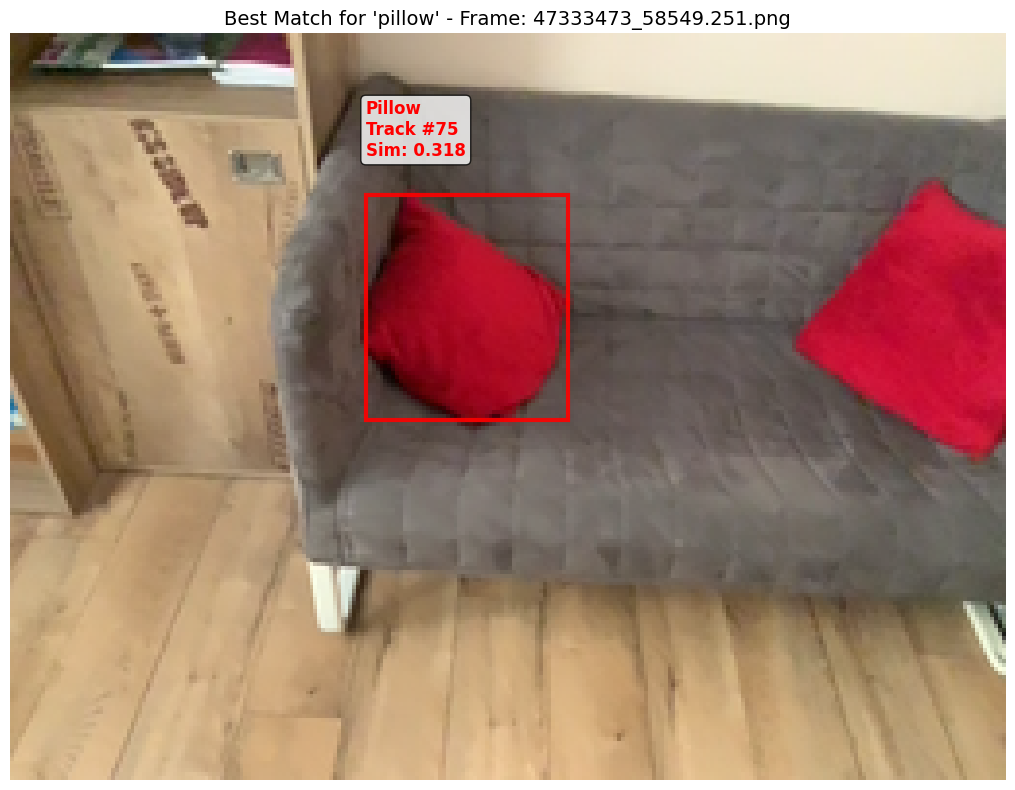


📋 SUMMARY:
  🎯 Chair: Track #44 (similarity: 0.294)
  🎯 Sofa: Track #52 (similarity: 0.282)
  🎯 Table: Track #44 (similarity: 0.280)
  🎯 Bed: Track #70 (similarity: 0.263)
  🎯 Pillow: Track #75 (similarity: 0.318)


In [66]:
# OPTION 1: Query specific furniture items and visualize only the best matches
# This will search for specific items and show only those that are found

if 'pipeline_results' in locals() and pipeline_results and 'object_tracker' in pipeline_results:
    print("🎯 SELECTIVE OBJECT QUERYING - Find specific furniture items")
    print("=" * 70)
    
    # Define the furniture items you want to find
    furniture_queries = ["chair", "sofa", "table", "bed", "pillow"]
    
    # Run selective visualization (3D + 2D for one item)
    query_results = run_selective_object_visualization(
        pipeline_results, 
        config,
        query_list=furniture_queries,
        show_3d=True,                    # Show 3D visualization of found objects
        show_2d_for="pillow",             # Show 2D frame for the "chair" (pick one)
        similarity_threshold=0.15        # Minimum similarity to consider a match
    )
    
    # Print summary of what was found
    if query_results:
        print(f"\n📋 SUMMARY:")
        for query, result in query_results.items():
            track_id = result['track']['id']
            similarity = result['similarity']
            print(f"  🎯 {query.capitalize()}: Track #{track_id} (similarity: {similarity:.3f})")
    
else:
    print("❌ Pipeline results not available.")
    print("📝 Please run the pipeline execution cell first.")

## 18. Notebook Summary

This notebook implements a complete object-centric 3D tracking and open-vocabulary querying pipeline with multiple visualization options:

### 🧠 **Core Technologies:**
- **DINOv2** for robust object tracking across frames
- **CLIP** for open-vocabulary text-to-object queries  
- **SAM** for object proposal generation
- **Dual-feature storage** enabling both tracking and querying

### 🎯 **Visualization Options:**

1. **Selective Object Querying** (NEW!) 
   - Query specific furniture items: "chair", "sofa", "table", "bed", "shelf"
   - Shows only the best matches in 3D space
   - Displays best 2D frame for selected object
   - Color-coded results with similarity scores

2. **Interactive 2D Slider Visualization**
   - Navigate through ALL tracked objects frame-by-frame
   - Color-coded bounding boxes for each track
   - Interactive slider control (matching Laura's implementation)

3. **3D Visualization of All Objects**
   - Complete 3D scene with all tracked objects
   - Wireframe bounding boxes and trajectories
   - Coordinate system and spatial relationships

### 📊 **Key Features:**
- **Configurable similarity thresholds** for selective querying
- **Multiple visualization modes** (selective vs. complete)
- **Interactive widgets** for frame navigation
- **Color-coded tracking** for easy identification
- **Modular, well-documented code** ready for extension

**Choose your visualization mode based on your needs: selective querying for specific items or complete visualization for full scene understanding!**